In [1]:
import random
import sys
import matplotlib.pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.basilisk_amm import ConstantProductPoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import random_swaps, constant_product_arbitrage
from model.amm.global_state import GlobalState, fluctuate_prices

# same seed, same parameters = same simulation result
random.seed(42)

price_dict = {
    'R1': 1,
    'R2': 1
}

initial_state = GlobalState(
    pools={
        'R1/R2': ConstantProductPoolState(
            tokens={
                'R1': 10000000,
                'R2': 10000000
            }
        )
    },
    agents = {
        'Trader': Agent(
            holdings={'R1': 100000, 'R2': 100000},
            trade_strategy=random_swaps(
                pool='R1/R2', 
                amount={
                    'R1': 1000,
                    'R2': 1000
                },
                randomize_amount=True
            )
        ),
        'Arbitrageur': Agent(
            holdings={'R1': 10000000, 'R2': 10000000},
            trade_strategy=constant_product_arbitrage('R1/R2')
        )
    },
    external_market=price_dict,
    evolve_function=fluctuate_prices(percent=1, bias=0.01)
)

events = run.run(initial_state, time_steps=5000)

events = processing.postprocessing(events, optional_params=['holdings_val', 'pool_val'])

Starting simulation...
Execution time: 3.395 seconds.
processing {'holdings_val', 'pool_val'}


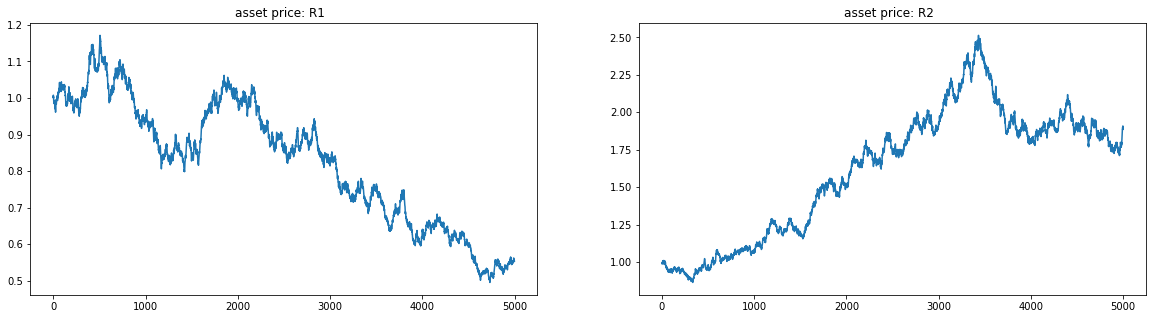

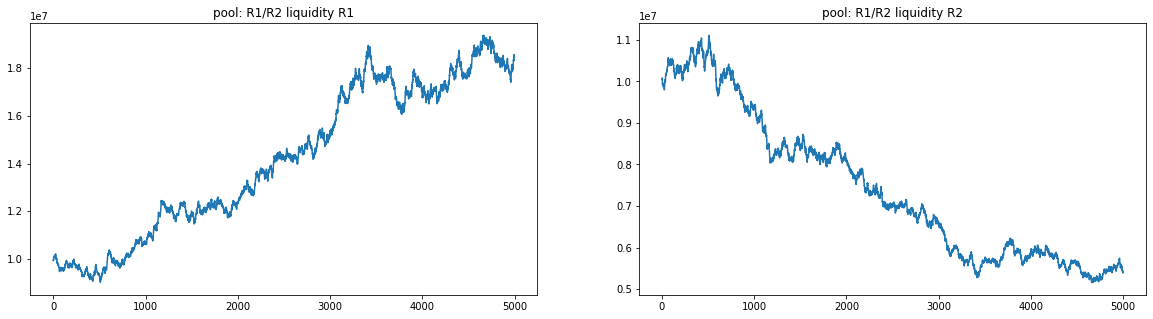

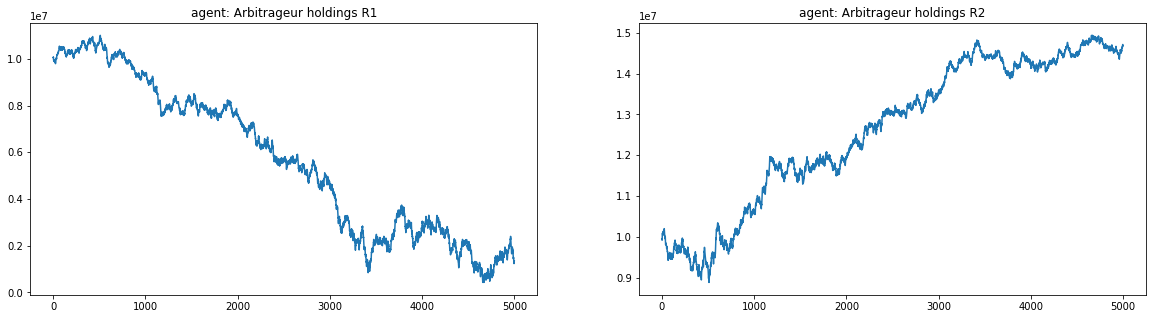

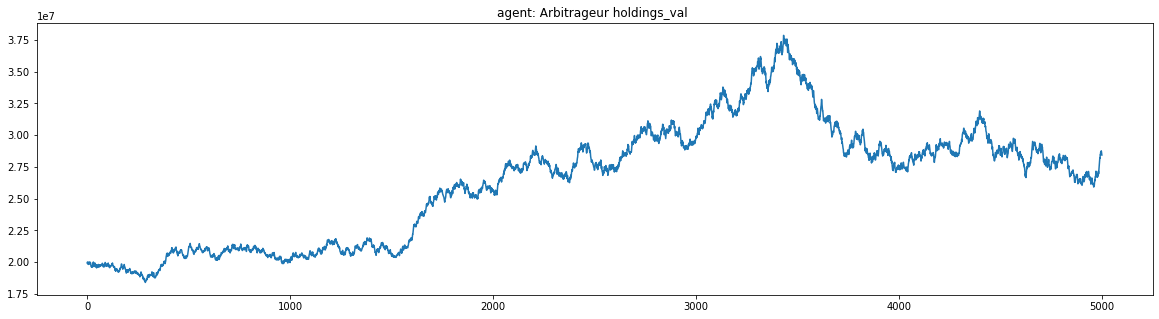

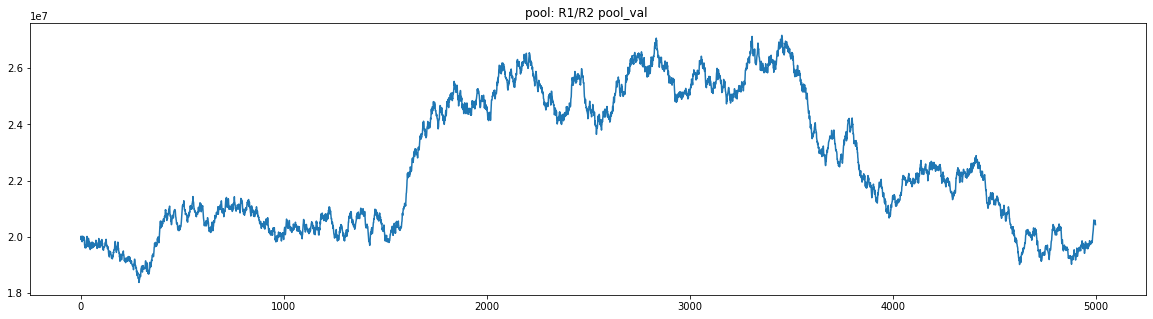

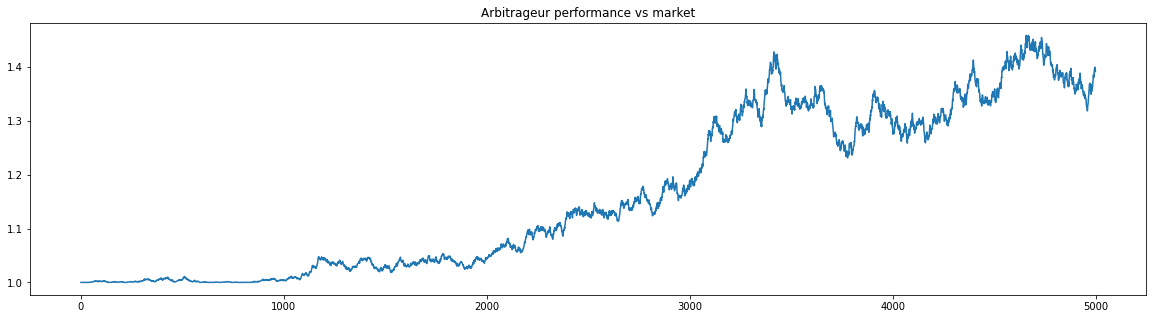

In [3]:
pu.plot(events, asset='all')
pu.plot(events, pool='R1/R2', prop='liquidity')
pu.plot(events, agent='Arbitrageur', prop='holdings')
pu.plot(events, agent='Arbitrageur', prop='holdings_val')
pu.plot(events, pool='R1/R2', prop='pool_val')
pool_val = pu.get_datastream(events, pool='R1/R2', prop='pool_val')
holdings_val = pu.get_datastream(events, agent='Arbitrageur', prop='holdings_val')
y = [holdings_val[i] / pool_val[i] for i in range(len(pool_val))]

plt.figure(figsize=(20,5))

ax = plt.subplot(111, title='Arbitrageur performance vs market')
ax.plot(range(5000), y, label='Profit')